In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import time
from multiprocessing import *
import sys
from LumA_Functions import *

from scipy.stats import mannwhitneyu as wrs
from scipy.stats import spearmanr as spearman
import operator
from tqdm import tqdm

## Part 1: Data Preprocessing

In [2]:
# Read comma separated data
data = pd.read_csv('data/SCANB.csv', index_col=False)
data_target = pd.read_csv('data/sampleinfo_SCANB_t.csv')
data = data.set_index('Unnamed: 0').T

#### Adding the target column to the dataframe and drop missing data

In [3]:
data['isLumA'] = 0
data = data.dropna(axis=1)
data 

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,0
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,0
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,2.430733,1.018666,-3.321928,6.882498,-1.911554,...,3.239924,0.516923,2.425054,3.074247,-1.070585,2.391182,6.167490,2.196925,3.182132,0
F2958repl,-3.321928,4.627216,-3.321928,-3.321928,-1.114219,2.097562,0.542301,-2.928133,6.972296,-1.581553,...,4.389831,0.127864,1.790839,2.953123,0.586012,2.082903,5.940774,2.351836,3.510877,0
F3057repl,-3.321928,6.965451,-3.321928,-3.321928,1.651384,1.418644,0.064947,-3.043577,8.223603,-1.267660,...,2.047489,0.952073,2.346690,3.476365,1.122679,3.046818,6.511327,3.383714,4.262995,0
F3085repl,-3.321928,4.531984,-3.321928,-3.321928,-0.594062,3.437225,0.149748,-3.160701,4.870941,-0.483202,...,4.393794,1.501286,2.705467,3.148965,-0.320549,2.185147,4.671022,1.636199,2.771947,0


#### Add the LumA information in the 'Target' column. We classify LumA = 1 and ~LumA = 0

In [4]:
data_target

,Unnamed: 0,samplename,ER,PAM50,time,event,Lympho,cluster2
0,1,F1,1,Basal,2367,0,2.602223,6
1,2,F2,2,LumA,2367,0,1.104544,5
2,3,F3,2,LumB,2168,1,0.581018,5
3,4,F4,2,LumA,2416,0,2.882004,6
4,5,F5,2,Normal,2389,0,1.013356,4
...,...,...,...,...,...,...,...,...
3064,3065,F2912repl,2,LumA,490,1,0.169352,5
3065,3066,F2958repl,2,Her2,1502,0,1.970687,6
3066,3067,F3057repl,2,LumA,1473,0,1.030736,4
3067,3068,F3085repl,2,LumB,1426,0,0.685621,5


In [5]:
for index in range(data_target.shape[0]):
    if data_target['PAM50'][index] == "LumA":
        data['isLumA'][index] = 1

data.head(10)

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,1
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,1
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
F6,-3.321928,2.556304,-3.321928,-3.321928,-1.759556,2.287331,0.055967,-3.240256,9.701680,-0.588587,...,3.096097,-0.054906,0.985107,3.054852,-0.045820,2.318660,7.711859,2.905767,3.892004,0
F9,-3.321928,-3.321928,-3.321928,-3.321928,0.494308,3.082967,0.083236,-3.266724,6.697515,-1.938000,...,2.424017,0.202236,1.353414,2.859130,0.718388,2.485166,6.256384,1.711416,3.344201,0
F10,-3.321928,3.223401,-3.321928,-3.321928,0.749841,2.391895,-0.512592,-3.194633,7.306434,-1.395287,...,2.752725,0.398657,1.773916,2.756937,-1.161449,1.816193,6.772483,2.195755,2.201702,1
F11,-3.321928,-3.321928,-3.321928,-3.321928,1.541830,1.953536,0.175489,-3.150456,7.518080,-1.048490,...,2.777566,0.458749,1.600170,3.293035,-1.442078,2.568569,6.222401,2.634517,3.384362,1
F12,-3.321928,5.265988,-3.321928,-3.321928,0.049312,3.831761,0.135180,-3.068973,5.808893,-1.740476,...,3.936359,0.418557,1.765641,3.477728,-0.066979,2.167204,5.761246,2.071037,3.082507,0


### Data Visualisation:

[1529 1540]


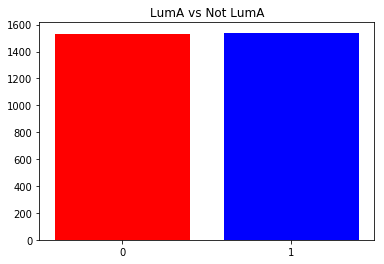

In [6]:
t = data['isLumA']
values, counts = np.unique(t, return_counts=True)
print(counts)
plt.bar(x=values,height=counts, color=["Red", "Blue"])
plt.xticks([0,1])
plt.title("LumA vs Not LumA")
plt.show()

#### Removing all columns with zero variance (i.e any constant value column)

In [7]:
# Removing zero variance cols
data = data.loc[:, (data != data.iloc[0]).any()] 
data 

Unnamed: 0,5_8S_rRNA,5S_rRNA,6M1-18,7M1-2,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,isLumA
F1,-3.321928,4.911099,-3.321928,-3.321928,-0.539253,0.598115,-1.352525,-3.213583,6.172477,-1.584899,...,3.044573,1.640598,2.425306,3.244432,-0.411950,1.468899,6.281767,1.774107,2.437227,0
F2,-3.321928,-3.321928,-3.321928,-3.321928,-0.576620,2.363673,-0.779430,-3.054421,7.113514,-2.329463,...,2.743902,0.684370,1.861781,2.727427,-0.452902,1.924761,7.169613,1.764214,2.876100,1
F3,-3.321928,-3.321928,-3.321928,-3.321928,-1.651323,2.647738,0.085410,-3.321928,5.641996,-2.221576,...,4.719843,-0.160076,1.365396,3.122333,0.594147,1.619277,6.683400,2.039246,2.929346,0
F4,-3.321928,3.656393,-3.321928,-3.321928,0.126633,1.378576,-0.334324,-3.321928,7.236769,-1.412293,...,4.157466,1.036271,2.038984,3.182823,-0.046619,1.969433,6.666306,2.771650,2.777674,1
F5,-3.321928,4.190104,-3.321928,-3.321928,0.783715,2.759643,0.984849,-3.321928,7.508171,-0.135133,...,1.024820,1.147535,2.032704,3.588842,0.808823,2.998474,6.479006,2.696269,3.957146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,-3.321928,-3.321928,-3.321928,-3.321928,-3.321928,2.430733,1.018666,-3.321928,6.882498,-1.911554,...,3.239924,0.516923,2.425054,3.074247,-1.070585,2.391182,6.167490,2.196925,3.182132,1
F2958repl,-3.321928,4.627216,-3.321928,-3.321928,-1.114219,2.097562,0.542301,-2.928133,6.972296,-1.581553,...,4.389831,0.127864,1.790839,2.953123,0.586012,2.082903,5.940774,2.351836,3.510877,0
F3057repl,-3.321928,6.965451,-3.321928,-3.321928,1.651384,1.418644,0.064947,-3.043577,8.223603,-1.267660,...,2.047489,0.952073,2.346690,3.476365,1.122679,3.046818,6.511327,3.383714,4.262995,1
F3085repl,-3.321928,4.531984,-3.321928,-3.321928,-0.594062,3.437225,0.149748,-3.160701,4.870941,-0.483202,...,4.393794,1.501286,2.705467,3.148965,-0.320549,2.185147,4.671022,1.636199,2.771947,0


In [8]:
X = data.drop('isLumA', axis=1)
y = data['isLumA']
# Seperate the data into two class, luminal-A and not-Luminal-A
lumA, not_lumA = X[y == 1], X[y != 1] # cahnge X and y and rename B
lumA.shape, not_lumA.shape

((1540, 28567), (1529, 28567))

In [9]:
wrs_dict = {}
for col in X.columns.values:
    current_wrs = wrs(lumA[col], not_lumA[col], alternative='two-sided') 
    wrs_dict[col] = current_wrs[1] # add p-value 
sorted_wrs_res = sorted(wrs_dict.items(), key=operator.itemgetter(1))

In [10]:
corr_threshold = 0.5
count_threshold = 1000

In [11]:
sorted_wrs_res[:10]

[('MYBL2', 5.1862491588629955e-282),
 ('PTTG1', 2.2944545421690907e-278),
 ('AF086186', 2.7138333702685002e-275),
 ('UBE2C', 4.2917326152643816e-274),
 ('CENPA', 5.751523661871411e-274),
 ('CDC45', 2.8021826710099352e-272),
 ('CDCA5', 9.634938707900045e-272),
 ('CEP55', 1.072295403185884e-271),
 ('FOXM1', 1.1637567709810184e-271),
 ('BIRC5', 2.3316560397898733e-270)]

In [9]:
try:
    final_set = np.loadtxt('Data/1000_features.csv',dtype='U', delimiter=',')
except:
    print("File not found, finding the best 1000 features now.")
    final_set = [sorted_wrs_res[0][0]]
    c = 1
    print(c,":",final_set[0])
    t = tqdm(sorted_wrs_res[1:])
    for gene, _ in t:
        rhos = [spearman(X[gene], X[selected_gene])[0] for selected_gene in final_set]
        max_rho = max(rhos)
        if max_rho < corr_threshold:
            final_set.append(gene)
            c += 1
            print(c,":",gene)
            t.set_postfix({"Gene Found":gene, "Current C": c})
        if c == count_threshold:
            break
            
    # save to csv file
    np.savetxt('Data/1000_features.csv', np.array(final_set), fmt="%10s", delimiter=',')

In [10]:
print(final_set[:10], "\n\nLength of final set: ",len(final_set))

['     MYBL2' '     WBP1L' '    UBXN10' '     LAMP5' '       C4A'
 ' RAB6C-AS1' ' C10orf107' '     CRIM1' '      ALAD' '       PIR'] 

Length of final set:  1000


#### We now remove all columsn from the dataframe apart form the 1000 features

In [11]:
final_set = [str(final_set[i]).lstrip() for i in range(len(final_set))]
data = data[final_set+['isLumA']]
data

Unnamed: 0,MYBL2,WBP1L,UBXN10,LAMP5,C4A,RAB6C-AS1,C10orf107,CRIM1,ALAD,PIR,...,ABHD14A,RANBP3L,KIAA1210,MT2A,IRF2BPL,ZDBF2,PPP3CB,PHLDB2,MAST1,isLumA
F1,4.769766,3.105591,1.300441,-1.280235,3.424119,-3.039664,-2.786345,3.931447,2.484433,3.931145,...,3.405339,-3.003645,-3.185945,8.407310,4.335755,-2.211299,4.040065,1.279597,1.196432,0
F2,2.807453,4.768438,2.903802,4.495057,4.979262,-0.169584,1.358216,4.305474,3.809362,0.567088,...,4.385579,-1.141621,-2.936423,8.313976,5.284966,-0.683314,4.041168,2.205206,-2.406273,1
F3,6.199798,3.831150,-1.148373,1.513277,3.110909,-1.823396,-2.075982,3.112670,2.971778,2.294293,...,3.638686,-1.515651,-1.713540,8.410180,4.505103,-0.297287,5.710827,2.035916,0.600333,0
F4,4.731736,4.259180,2.228464,3.507288,3.275210,-0.100264,-2.900630,4.404896,3.900465,1.775014,...,3.250037,-0.320601,-2.743856,9.594487,5.782479,-0.681485,4.656234,1.661221,-2.492361,1
F5,-0.328395,4.744023,2.293257,2.624391,3.553610,-1.238575,-2.076773,5.142328,4.306626,2.002166,...,3.918317,1.848518,-2.752241,7.487615,5.507696,0.790142,4.491866,3.089295,-2.243398,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F2912repl,3.177255,4.835989,2.662923,4.329317,5.465341,1.183283,-2.142672,4.539971,3.882858,1.188401,...,3.560797,0.189488,-2.975420,9.179063,5.420846,-1.564688,3.781938,2.973921,-0.300123,1
F2958repl,3.871206,4.137340,-0.647599,3.414219,3.421159,-0.953665,-1.259492,4.263778,4.061591,3.746590,...,3.367649,-1.778330,-3.190194,8.829751,4.411521,-1.024502,4.236384,1.240313,-1.512447,0
F3057repl,-0.410189,4.725192,3.242447,1.678981,5.558393,0.887003,2.723576,6.220800,4.246469,0.858545,...,3.569895,1.907166,-2.314295,9.387875,5.194875,0.637177,4.694153,2.329931,-2.347080,1
F3085repl,2.798651,4.667153,2.712688,0.250127,2.272632,-3.321928,-2.525334,2.988177,4.488635,3.119031,...,4.429837,0.297074,-3.321928,8.223577,5.128780,-2.596809,5.068293,0.286807,-1.483957,0


## Part 5: Using Feature Importance for start of feature selection:

### Using Ranked Data:

In [12]:
def bin_rank(data, bins=5):
    data = pd.DataFrame(data)
    rank_data = data.rank(axis=1)
    for i, row in rank_data.iterrows():
        rank_data.loc[i, :] = pd.cut(row, bins=bins, labels=False)
    return rank_data.values

In [13]:
def splitData(data, isRanked):
    if isRanked:
        X = data.drop('isLumA', axis=1)
        # Ranking and binning data
        X = bin_rank(X.values)
    else:
        X = data.drop('isLumA', axis=1).values
    y = data['isLumA'].values
    # Split into training and validation sets
    np.random.seed(42)
    indices = np.random.permutation(X.shape[0])
    idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
    X_train, X_val = X[idx_train], X[idx_val]
    y_train, y_val = y[idx_train], y[idx_val]
    return X_train, X_val, y_train, y_val

#### Decision Trees:


In [14]:
from sklearn import tree
X_train, X_val, y_train, y_val = splitData(data, True)
dt = tree.DecisionTreeClassifier().fit(X_train, y_train)

In [15]:
y_pred = dt.predict(X_val)
print('Accuracy of Decision tree classifier on test set: {:.2f}'.format(dt.score(X_val, y_val)))

Accuracy of Decision tree classifier on test set: 0.80


In [27]:
# Get an array of importance for every feature
dt_feature_importance = dt.feature_importances_
# Get the indicies of the top 20 most important features
dt_idx_feature_importance = np.argpartition(dt_feature_importance, -20)[-20:]
# Get the actual features
dt_rank_top_features = [data.columns[i] for i in dt_idx_feature_importance]
print(dt_rank_top_features,"\n", dt_idx_feature_importance)

['CCSAP', 'KYNU', 'ANKRD30A', 'CARD9', 'CHRNA5', 'BHLHE41', 'KIAA0040', 'C18orf56', 'TMSB15A', 'CCHCR1', 'SHC2', 'MAP2K1', 'CALML3', 'CDCA7L', 'GALT', 'C9orf40', 'LINC00940', 'LAMP5', 'UBXN10', 'MYBL2'] 
 [103 415  25 769 151 156 170 171 198 970 250 655 116 598 981 497 482   3
   2   0]


Now, we will use this array as our base array and run the feature selection algorithm

In [30]:
from LumA_Functions import *

In [31]:
X_train, X_val, y_train, y_val = splitData(data, False)
max_rounds = 2
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_rounds, 
                                                 cpu_count, dt_idx_feature_importance, dt_rank_top_features)

Round: 0 Features found so far are:  ['BC041347', 'SHC2', 'CCSAP', 'UBXN10', 'C9orf40', 'TMSB15A', 'CARD9', 'GALT', 'KIAA0040', 'LINC00940', 'ANKRD30A', 'C18orf56', 'CCHCR1', 'MAP2K1', 'LAMP5', 'CDCA7L', 'BHLHE41', 'MYBL2', 'CHRNA5', 'CALML3']
Round: 1 Features found so far are:  ['BC041347', 'RHOBTB1', 'SHC2', 'CCSAP', 'UBXN10', 'C9orf40', 'TMSB15A', 'GALT', 'KIAA0040', 'LINC00940', 'ANKRD30A', 'C18orf56', 'CCHCR1', 'MAP2K1', 'LAMP5', 'CDCA7L', 'BHLHE41', 'MYBL2', 'CHRNA5', 'CALML3']


In [21]:
for f in features_found:
    print(f)

{'Feature': ['DIRAS3', 'ANKRD30A', 'CARD9', 'CHRNA5', 'KYNU'], 'Iteration': 1, 'Training accuracy': 0.7731160896130346, 'Validation Accuracy': 0.758957654723127, 'Time': 8.77839207649231}
{'Feature': ['DIRAS3', 'ANKRD30A', 'FAM198A', 'CHRNA5', 'KYNU'], 'Iteration': 2, 'Training accuracy': 0.7955193482688391, 'Validation Accuracy': 0.7719869706840391, 'Time': 8.619940280914307}


#### Random Forest:


In [11]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_val, y_train, y_val = splitData(data, True)
rf = RandomForestClassifier().fit(X_train, y_train)

In [26]:
y_pred = rf.predict(X_val)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_val, y_val)))

Accuracy of Random Forest classifier on test set: 0.88


In [29]:
# Get an array of importance for every feature
rf_feature_importance = rf.feature_importances_
# Get the indicies of the top 20 most important features
rf_idx_feature_importance = np.argpartition(rf_feature_importance, -20)[-20:]
# Get the actual features
rf_rank_top_features = [data.columns[i] for i in rf_idx_feature_importance]
print(rf_rank_top_features)

['RHOJ', 'MCM6', 'SPC24', 'RAB6C', 'CMC2', 'NCAPD2', 'CENPF', 'MGC4836', 'PTTG1', 'KIF2C', 'HEXIM1', 'UBXN10', 'SLC24A2', 'C4A', 'CX3CR1', 'CDCA8', 'KIF14', 'KIF11', 'FIGNL1', 'XRCC2']


Now, we will use this array as our base array and run the feature selection algorithm

In [ ]:
X_train, X_val, y_train, y_val = splitData(data, False)
max_features = 1
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, 
                                                 cpu_count, rf_idx_feature_importance, rf_rank_top_features)

In [ ]:
for f in features_found:
    print(f)

#### Logistic Regression:

In [30]:
X_train, X_val, y_train, y_val = splitData(data, True)
lr = LogisticRegression().fit(X_train, y_train)

In [31]:
y_pred = lr.predict(X_val)
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(lr.score(X_val, y_val)))

Accuracy of Random Forest classifier on test set: 0.90


In [33]:
# Get an array of importance for every feature
lr_feature_importance = lr.coef_[0]
# Get the indicies of the top 20 most important features
lr_idx_feature_importance = np.argpartition(lr_feature_importance, -20)[-20:]
# Get the actual features
lr_rank_top_features = [data.columns[i] for i in lr_idx_feature_importance]
print(lr_rank_top_features)

['DQ571149', 'MAPT-AS1', 'NAP1L2', 'L13714', 'MIR6752', 'MIR1204', 'SNAR-G2', 'MIR429', 'ACTG2', 'DL490813', 'KRT14', 'SNORD117', 'MIR1273D', 'KRT17', 'MIR6784', 'PGR', 'MYL7', 'MAPT', 'KRT5', 'SFRP1']


In [ ]:
#Now, we will use this array as our base array and run the feature selection algorithm

X_train, X_val, y_train, y_val = splitData(data, False)
max_features = 1
cpu_count = multiprocessing.cpu_count()
# Run with threadPool and single thread
features_found,accu_acheived = forward_selection(data,X_train, y_train, X_val, y_val, max_features, 
                                                 cpu_count, lr_idx_feature_importance, lr_rank_top_features)

for f in features_found:
    print(f)